In [407]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, plot_confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline  
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings("ignore")
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [408]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [409]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [410]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [411]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Check for missing values - We can see many of the cabin numbers are missing, some ages, and two embarked

In [412]:
# df.rename(columns={'Embarked': 'Port'}, inplace=True)
# print(df.isnull().sum()) 

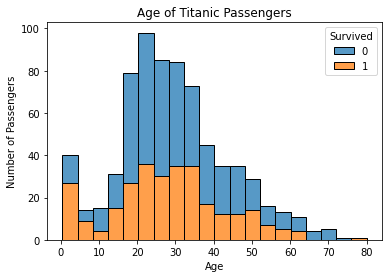

In [413]:
sns.histplot(data=df_train, x='Age', hue='Survived', multiple='stack')
# plt.hist(df['Age'], bins=10)
plt.title('Age of Titanic Passengers')
plt.xlabel('Age')
plt.ylabel('Number of Passengers')
plt.show()

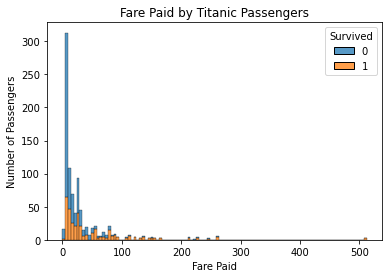

In [414]:
sns.histplot(data=df_train, x='Fare', hue='Survived', multiple='stack')
plt.title('Fare Paid by Titanic Passengers')
plt.xlabel('Fare Paid')
plt.ylabel('Number of Passengers')
plt.show()

Data columns not used in model: 
- Cabin, because too many missing values 
- Name, not relevant 
- Ticket, not relevant
- Embarked - when using ohe pd.get_dummies() to separate ports into binary columns their feature importances were small in a RandomForestClassifier so they did not help the model much so they were removed
- Age, too many null values
- SibSp and Parch - combined into new feature family_size

In [415]:
df_train['Sex'] = df_train['Sex'].apply(lambda x: 1 if x == 'male' else 0)
df_test['Sex'] = df_test['Sex'].apply(lambda x: 1 if x == 'male' else 0)
print("New Sex Column Example Data")
print(df_train['Sex'].head())

df_train['is_child'] = df_train.apply(lambda row: 1 if row['Age'] < 18 else 0, axis=1)
df_test['is_child'] = df_test.apply(lambda row: 1 if row['Age'] < 18 else 0, axis=1)
print("\nNew Is Child Column Example Data")
print(df_train.is_child.head())

df_train['family_size'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['family_size'] = df_test['SibSp'] + df_test['Parch'] + 1
print("\nNew Family Size Column Example Data")
print(df_train.family_size.head())

df_test.Fare.fillna(df_test.Fare.median(), inplace=True)
df_train.Age.fillna(df_train.Age.median(), inplace=True)
df_test.Age.fillna(df_train.Age.median(), inplace=True)


# add title column (from name)

New Sex Column Example Data
0    1
1    0
2    0
3    0
4    1
Name: Sex, dtype: int64

New Is Child Column Example Data
0    0
1    0
2    0
3    0
4    0
Name: is_child, dtype: int64

New Family Size Column Example Data
0    2
1    2
2    1
3    2
4    1
Name: family_size, dtype: int64


In [416]:
# Code to get port columns from Embarked - ended up not using due to lack of relevance to classification

# ohe_port = OneHotEncoder()
# enc_port_df = pd.DataFrame(ohe_port.fit_transform(df[['Port']]).toarray())
# enc_port_df.rename(columns={0: 'Port_C', 1: 'Port_Q', 2: 'Port_S'}, inplace=True)
# df = df.join(enc_port_df)
# df = df.join(pd.get_dummies(df['Port'], prefix='Port'))

In [417]:
features = ['Pclass', 'Sex', 'family_size', 'is_child', 'Fare', 'Age']
# ideally use age as a feature but the problem is the nas in it
X_train = df_train[features]
X_test = df_test[features]
y = df_train['Survived']

In [418]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Accuracy: 
  0.978675645342312
Cross Validation Accuracies:  
 [0.75977654 0.82022472 0.88202247 0.80898876 0.79775281]
Mean CV Accuracy:  
 0.8137530600715586


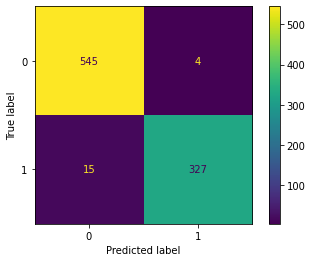

In [419]:
clf = RandomForestClassifier()
clf.fit(X_train, y)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
cv = cross_val_score(clf, X_train, y, cv=skf)
print("Accuracy: \n ", accuracy_score(y, clf.predict(X_train)))
print("Cross Validation Accuracies:  \n", cv)
print("Mean CV Accuracy:  \n", np.mean(cv))
plot_confusion_matrix(clf, X_train, y) 



In [420]:
models = [
    LogisticRegression(max_iter=1000, random_state = 13),
    KNeighborsClassifier(),
    RandomForestClassifier(random_state = 13),
    GradientBoostingClassifier(random_state = 13),
    SVC(probability=True, max_iter = 1000, random_state = 13),
    SGDClassifier(max_iter = 5000, random_state = 13)
]
# maybe add adaboost??

model_grids = [
    [{'C':[1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1, 5, 1e1, 5e1, 1e2, 5e2, 1e3]}],
    [{'n_neighbors':[5,7,9,11, 13, 15, 17, 19], 
        'metric': ['euclidean', 'manhattan', 'minkowski']}],
    [{'criterion':['gini','entropy'],
        'n_estimators': [1000],
        'max_depth' : [5], 
        'min_samples_split' : [1.0,2,5,10,15],
        'min_samples_leaf': [1,2,5,10], 
        'max_features': ['log2', 'sqrt', None]}],
    [{'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'n_estimators': [1000],
        'max_depth' : [5, 8, 15, None], 
        'min_samples_split' : [1.0,2,5,10],
        'min_samples_leaf': [1,2,5,10], 
        'max_features': ['log2', 'sqrt', 'auto', 'None']}],
    [{'C':[1e-1, 1, 1e1],
        'kernel': ['rbf', 'poly']}],  
    [{"loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
        "alpha" : [0.01],
        "penalty" : ["l2", "l1", "none"]}],         
]

In [421]:
# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore")
#     for i,j in zip(models, model_grids):
#         grid = RandomizedSearchCV(estimator=i, param_distributions=j, n_iter = 100, scoring='f1_weighted', cv = skf, n_jobs=-1, verbose=2)
#         grid.fit(X_train, y)
#         best_f1 = grid.best_score_
#         best_param = grid.best_params_
#         print('{}:\nBest F1 : {:.4f}'.format(str(i),best_f1))
#         print('Best Parameters : ', best_param)
#         print('\n----------------\n')


Fitting 5 folds for each of 13 candidates, totalling 65 fits
LogisticRegression(max_iter=1000, random_state=13):
Best F1 : 0.7961
Best Parameters :  {'C': 0.05}

----------------

Fitting 5 folds for each of 24 candidates, totalling 120 fits
KNeighborsClassifier():
Best F1 : 0.8257
Best Parameters :  {'n_neighbors': 7, 'metric': 'manhattan'}

----------------

Fitting 5 folds for each of 100 candidates, totalling 500 fits


KeyboardInterrupt: 

LogisticRegression(max_iter=1000, random_state=13):

Best F1 : 0.7973

Best Parameters :  {'C': 0.05}

----------------

KNeighborsClassifier():

Best F1 : 0.8207

Best Parameters :  {'n_neighbors': 7, 'metric': 'euclidean'}

----------------

RandomForestClassifier(random_state=13):

Best F1 : 0.8289

Best Parameters :  {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 5, 'criterion': 'gini'}

----------------

GradientBoostingClassifier(random_state=13):

Best F1 : 0.8321

Best Parameters :  {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 5, 'learning_rate': 0.01}

----------------

SVC(max_iter=1000, probability=True, random_state=13):

Best F1 : 0.8198

Best Parameters :  {'kernel': 'rbf', 'C': 1}

----------------

SGDClassifier(max_iter=5000, random_state=13):

Best F1 : 0.7977

Best Parameters :  {'penalty': 'l2', 'loss': 'log', 'alpha': 0.01}

----------------

In [422]:
models_tuned = [
    LogisticRegression(max_iter=1000, C=0.05, random_state = 13),
    KNeighborsClassifier(n_neighbors=7, metric='euclidean'),
    RandomForestClassifier(random_state = 13, n_estimators = 1000, min_samples_split = 2, min_samples_leaf=2, max_features=None, max_depth=5, criterion='gini'),
    GradientBoostingClassifier(random_state = 13, n_estimators = 1000, min_samples_split = 5, min_samples_leaf = 2, max_features = 'auto', max_depth = 5, learning_rate = 0.01),
    SVC(probability=True, max_iter = 1000, random_state = 13, kernel = 'rbf', C = 1),
    SGDClassifier(max_iter = 5000, random_state = 13, penalty = 'l2', loss = 'log', alpha = 0.01)
]

In [423]:
tuned_model_stats = []

for i in range(len(models_tuned)):
    model_stats = []
    model = models_tuned[i]
    model.fit(X_train, y)
    y_pred = model.predict(X_train)
    y_test = np.array(y)

    accuracies = cross_val_score(estimator = model, X = X_train, y = y, cv = skf)
    test_acc = accuracy_score(y_test, y_pred)
    cr = classification_report(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average= 'weighted')
    recall = recall_score(y_test, y_pred, average= 'weighted')
    f1 = f1_score(y_test, y_pred, average= 'weighted')
   
    print(str(model), ':')
    
    print('Accuracy Score: {:.4f}'.format(test_acc))
    print("K-Fold Validation Mean Accuracy: {:.4f} %".format(accuracies.mean()*100))
    print("Classification report: ")
    print(cr)
    
    print('-----------------------------------\n')
    model_stats.append(str(model)[:str(model).find('(')])
    model_stats.append(accuracies.mean())
    model_stats.append(test_acc)
    model_stats.append(precision)
    model_stats.append(recall)
    model_stats.append(f1)
    tuned_model_stats.append(model_stats)

LogisticRegression(C=0.05, max_iter=1000, random_state=13) :
Accuracy Score: 0.8036
K-Fold Validation Mean Accuracy: 80.0257 %
Classification report: 
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       549
           1       0.78      0.67      0.72       342

    accuracy                           0.80       891
   macro avg       0.80      0.78      0.79       891
weighted avg       0.80      0.80      0.80       891

-----------------------------------

KNeighborsClassifier(metric='euclidean', n_neighbors=7) :
Accuracy Score: 0.8575
K-Fold Validation Mean Accuracy: 81.9333 %
Classification report: 
              precision    recall  f1-score   support

           0       0.86      0.91      0.89       549
           1       0.85      0.77      0.80       342

    accuracy                           0.86       891
   macro avg       0.86      0.84      0.85       891
weighted avg       0.86      0.86      0.86       891

----------

In [424]:
df_tuned = pd.DataFrame(tuned_model_stats, columns= ['Model','Cross-val Acc','Test Accuracy','Precision','Recall', 'F1'])
df_tuned.sort_values(by = ['F1'], inplace = True, ascending = False)
df_tuned

,Model,Cross-val Acc,Test Accuracy,Precision,Recall,F1
3,GradientBoostingClassifier,0.829433,0.941639,0.942417,0.941639,0.941161
2,RandomForestClassifier,0.824933,0.859708,0.862712,0.859708,0.856398
1,KNeighborsClassifier,0.819333,0.857464,0.856921,0.857464,0.855930
4,SVC,0.830544,0.832772,0.831824,0.832772,0.830584
0,LogisticRegression,0.800257,0.803591,0.802067,0.803591,0.800209
5,SGDClassifier,0.799134,0.801347,0.799500,0.801347,0.798427


In [431]:
indiv_clfs = {
    # ('log reg', Pipeline([('classifier', LogisticRegression(max_iter=1000, C=0.05, random_state = 13))])),
    ('knn', Pipeline([('classifier', KNeighborsClassifier(n_neighbors=7, metric='euclidean'))])),
    ('random forest', Pipeline([('classifier', RandomForestClassifier(random_state = 13, n_estimators = 1000, min_samples_split = 8, min_samples_leaf = 2, max_features = None, max_depth = 5, criterion = 'gini'))])),
    ('gradient boosting', Pipeline([('classifier', GradientBoostingClassifier(random_state = 13, n_estimators = 1000, min_samples_split = 5, min_samples_leaf = 2, max_features = 'auto', max_depth = 5, learning_rate = 0.01))])),
    ('svc', Pipeline([('classifier', SVC(probability=True, max_iter = 1000, random_state = 13, kernel = 'rbf', C = 1))]))
    # ('sgd', Pipeline([('classifier', SGDClassifier(max_iter = 5000, random_state = 13, penalty = 'l2', loss = 'log', alpha = 0.01))]))
}
final_est = LogisticRegression(max_iter=1000)
#todo: tune final est

In [432]:
clf = StackingClassifier(estimators=indiv_clfs, final_estimator=final_est)
clf.fit(X_train, y)
print("Stacking:", clf.score(X_train, y))

Stacking: 0.8933782267115601


In [ ]:
# clf = GradientBoostingClassifier(random_state = 13, n_estimators = 1000, min_samples_split = 5, min_samples_leaf = 2, max_features = 'auto', max_depth = 5, learning_rate = 0.01)
# clf.fit(X_train, y)
# print("Gradient Boosting", clf.score(X_train, y))

Gradient Boosting 0.9102132435465768


In [429]:
predictions = clf.predict(X_test)
output = pd.DataFrame({'PassengerId': df_test.PassengerId, 'Survived': predictions})
output.to_csv('ensemble_submission.csv', index=False)